In [101]:
from thermo.cost_model.model import HeatModel
import numpy as np
import pandas as pd
import networkx as nx

In [24]:
# np.set_printoptions(suppress=True)

### Minimal example

In [271]:
As = np.array([[0,1,1,0],[1,0,0,1],[1,0,0,1],[0,1,1,0]]) # Adjacency matrix of rooms

In [280]:
state = np.zeros(12)
state[4] = 1 # Room 2 is occupied at time t_0 (time slots t_0, t_1, t_2)
state.reshape(-1, 4)

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [276]:
model = HeatModel(As, n_time_slots=3)

In [281]:
room_optimality = model.run(state)
room_optimality.reshape(-1, 4) # rows are time slots, columns are rooms

array([[     0.5,      1. ,      1. ,      1. ],
       [100001. ,      0.5,      0.5,      1. ],
       [     0.5,      1. ,      1. ,      1. ]])

***

### Mock data

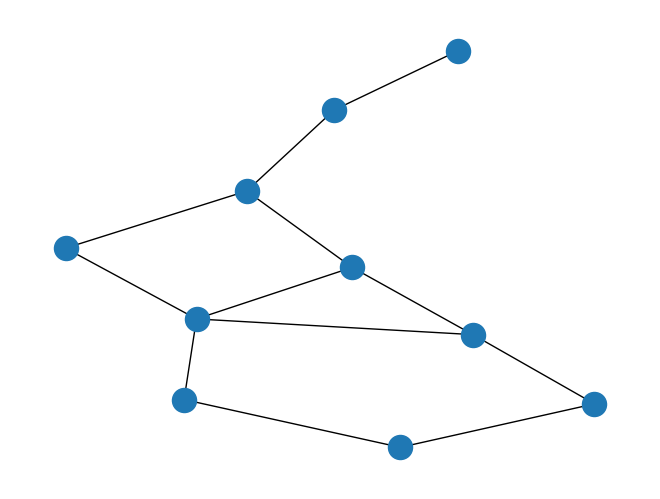

In [226]:
# N_ROOMS = 10
# G = nx.generators.random_graphs.gnp_random_graph(N_ROOMS, p=0.2, seed=4812)
# nx.draw(G)

In [300]:
# As = nx.adjacency_matrix(G).todense()

As = np.array([
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
])

### Mock state

In [309]:
# state = np.zeros(12)
# state[4] = 1 # Room 1 is occupied at time t_1 (time slots t_0, t_1, t_2)

TIMESLOTS = 3
state = np.zeros((TIMESLOTS, As.shape[0]))
state[0, 2] = 1 # Room C is occupied at time t_0 (time slots t_0, t_1, t_2)
state[0, 3] = 1 # Room D is occupied at time t_0 (time slots t_0, t_1, t_2)
state[1, 4] = 1 # Room E is occupied at time t_1 (time slots t_0, t_1, t_2)
state[2, 6] = 1 # Room G is occupied at time t_2 (time slots t_0, t_1, t_2)

In [310]:
state

array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [311]:
state = state.flatten()

### Define model

In [312]:
model = HeatModel(As, n_time_slots=TIMESLOTS)

### Run model

In [313]:
room_optimality = model.run(state)
room_optimality.reshape(-1, 10) # rows are time slots, columns are rooms

array([[     1. ,      0.5, 100000.5, 100000.5,      0.5,      1. ,
             0.5,      1. ,      1. ,      0.5],
       [     1. ,      1. ,      0.5,      0.5, 100001. ,      0.5,
             0. ,      0.5,      1. ,      1. ],
       [     1. ,      0.5,      1. ,      0.5,      0. ,      1. ,
        100001. ,      1. ,      1. ,      1. ]])

In [314]:
room_optimality.reshape(-1, 10).T # columns are time slots, rows are rooms

array([[     1. ,      1. ,      1. ],
       [     0.5,      1. ,      0.5],
       [100000.5,      0.5,      1. ],
       [100000.5,      0.5,      0.5],
       [     0.5, 100001. ,      0. ],
       [     1. ,      0.5,      1. ],
       [     0.5,      0. , 100001. ],
       [     1. ,      0.5,      1. ],
       [     1. ,      1. ,      1. ],
       [     0.5,      1. ,      1. ]])

### Check recommendations

In [315]:

def to_frame(optimalities, room_names):
    
    opt = optimalities.reshape(-1, len(room_names))
    return pd.DataFrame(
        opt,
        columns=room_names,
        index=(f't_{i}' for i in range(opt.shape[0])),
    )

optimality_df = to_frame(
    room_optimality, 
    room_names=('Room A', 'Room B', 'Room C', 'Room D', 'Room E', 'Room F', 'Room G', 'Room H', 'Room I', 'Room J')
)
optimality_df

,Room A,Room B,Room C,Room D,Room E,Room F,Room G,Room H,Room I,Room J
t_0,1.0,0.5,100000.5,100000.5,0.5,1.0,0.5,1.0,1.0,0.5
t_1,1.0,1.0,0.5,0.5,100001.0,0.5,0.0,0.5,1.0,1.0
t_2,1.0,0.5,1.0,0.5,0.0,1.0,100001.0,1.0,1.0,1.0


In [320]:
def show_recommendations(df):
    """ Color code recommendations in table."""
    return (
        df.replace(100001, np.nan).replace(100000.5, np.nan)
        .style.background_gradient(cmap='viridis', high=0, low=1, axis=1)
        .format(precision=1, na_rep="BOOKED")
    )
show_recommendations(optimality_df)

,Room A,Room B,Room C,Room D,Room E,Room F,Room G,Room H,Room I,Room J
t_0,1.0,0.5,BOOKED,BOOKED,0.5,1.0,0.5,1.0,1.0,0.5
t_1,1.0,1.0,0.5,0.5,BOOKED,0.5,0.0,0.5,1.0,1.0
t_2,1.0,0.5,1.0,0.5,0.0,1.0,BOOKED,1.0,1.0,1.0


In [321]:
def list_recommendations(df):
    """ List recommendations in table."""
    return (
        df
        .reset_index()
        .melt(id_vars='index')
        .rename(columns={'index': 'Time Slot', 'variable': 'Room', 'value': 'Optimality'})
        .sort_values(by=['Optimality', 'Time Slot'])
        [lambda d: d['Optimality'] < 100]
    )
list_recommendations(optimality_df)

,Time Slot,Room,Optimality
19,t_1,Room G,0.0
14,t_2,Room E,0.0
3,t_0,Room B,0.5
12,t_0,Room E,0.5
18,t_0,Room G,0.5
27,t_0,Room J,0.5
7,t_1,Room C,0.5
10,t_1,Room D,0.5
16,t_1,Room F,0.5
22,t_1,Room H,0.5
